# Computer Vision and Deep Learning - Laboratory 6
 
Congratulations, you made it till the last laboratory of the semester. This laboratory will be a bit different: it contains two parts and you can __choose__ at your own preference which of them you want to solve.  Of course, you can choose to solve both of them.
 
The first part is related to _visualization_, while the second one is related to sequence models and vision transformers.


In [2]:
import cv2.cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

color = 'red'
plt.rcParams['text.color'] = color
plt.rcParams['axes.labelcolor'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color

print("done")

done


# Part 1. Visualizing what neural networks learn


For this part you can either work with a neural network that you trained (perhaps for your project), or with a pre-trained model from tensorflow.
 
For illustration purposes, I will load the Resnet network, pre-trained on Imagenet and, of course, an image of a cat.


--2021-12-09 06:43:40--  https://img.freepik.com/free-photo/cat-white-background_155003-20502.jpg?size=626
Resolving img.freepik.com (img.freepik.com)... 23.200.149.225, 2600:140e:6:bbf::30ec, 2600:140e:6:b8d::30ec
Connecting to img.freepik.com (img.freepik.com)|23.200.149.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25662 (25K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  25.06K  --.-KB/s    in 0.01s   

2021-12-09 06:43:41 (1.90 MB/s) - ‘cat.jpg’ saved [25662/25662]



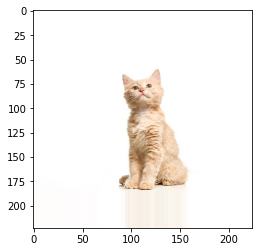

In [ ]:
#!wget -O cat.jpg https://img.freepik.com/free-photo/cat-white-background_155003-20502.jpg?size=626&ext=jpg

(224, 224, 3)


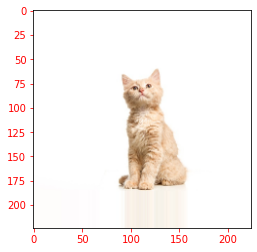

In [4]:
img = cv2.imread('cat.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
factor = 224.0/img.shape[1]
img = cv2.resize(img, None, fx=factor, fy=factor)
if img.shape[0] > img.shape[1]:
  img = cv2.copyMakeBorder(img, top=0, bottom=0, left=(img.shape[0] - img.shape[1])//2, right=(img.shape[0] - img.shape[1])//2,
                          borderType=cv2.BORDER_REPLICATE)
else:
    img = cv2.copyMakeBorder(img, top=(img.shape[1] - img.shape[0])//2, bottom=(img.shape[1] - img.shape[0])//2, left=0, right=0,
                          borderType=cv2.BORDER_REPLICATE)
img = cv2.resize(img, (224, 224))
print(img.shape)
plt.imshow(img)

In [5]:
resnet50_model = ResNet50(weights='imagenet')
resnet50_model.summary()
#tf.keras.utils.plot_model(resnet50_model, show_shapes=True, show_dtype=True)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Display the filters in the first and second convolutional layer

Get the filters in the first and second convolutional layers and plot them. The filters in the first convolutional layer should be displayed as color images, while for the filters in the second layer you should display each channel individually as a grayscale image.

Identify the names of these two layers and then use _layer.get_weights()_ to access the values of the filters.

(7, 7, 3, 64)
(147, 64)
(1, 64)


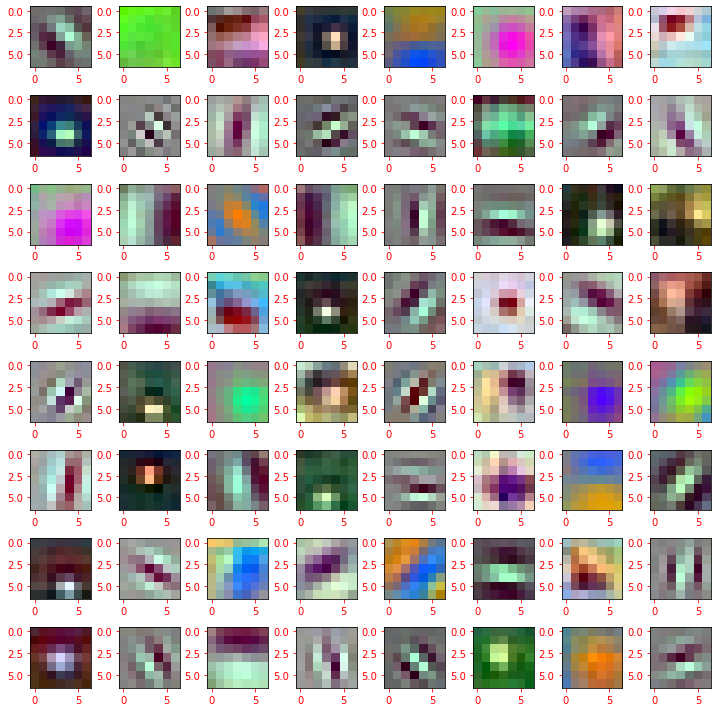

In [18]:
# TODO your code here
layer1_weights = resnet50_model.get_layer("conv1_conv").get_weights()[0]
print(layer1_weights.shape)
layer1_weights_reshaped = np.reshape(layer1_weights, (-1, 64))
print(layer1_weights_reshaped.shape)
val_min = np.min(layer1_weights_reshaped, axis=0, keepdims=True)
print(val_min.shape)
normalized_layer = (layer1_weights - val_min)/(np.max(layer1_weights_reshaped, axis=0, keepdims=True) - val_min)

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    #val_min = np.min(layer1_weights[:, :, :, i])
    #val_max = np.max(layer1_weights[:, :, :, i])
    #normalized_weights = (layer1_weights[:, :, :, i]-val_min) / (val_max - val_min)
    plt.imshow(normalized_layer[:, :, :, i])

plt.tight_layout()
plt.show()

In [20]:
layer2_weights = resnet50_model.get_layer("conv2_block1_2_conv").get_weights()[0][:2]
print(layer2_weights.shape)
# canal cu canal, in total 128

(3, 3, 64, 64)


## Saliency map via image occlusions
 
This visualization technique will output a heatmap which will highlight the regions that the model finds important when predicting a certain class.
 
The implementation is straightforward: you just slide an occluding patch over the input image, and, for each position of the patch, feed the occluded image to the network and store the predictions (probas) of the model.
 
Finally, display (as a heatmap) the probability of the correct class.


[[('n02123045', 'tabby', 0.26574683), ('n02123159', 'tiger_cat', 0.1599793), ('n02124075', 'Egyptian_cat', 0.13808134), ('n02123394', 'Persian_cat', 0.07301893), ('n03482405', 'hamper', 0.029026542)]]
(289, 1000)
()


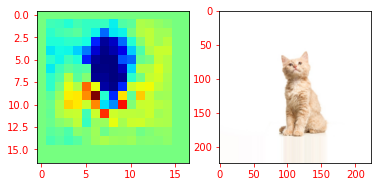

In [17]:
import sys
def compute_saliency_map(model, img, patch_size, stride):
    """
    Succesivelly occlude the input imagw with a gray square patch of size patch_size.
    When sliding the patch over the input image a step equal to stride is used.
    """
  
    # TODO your code here: pad the input image with patch_size/2
    padded_image = np.pad(img, ((patch_size//2, patch_size//2), (patch_size//2, patch_size//2), (0, 0)), mode="edge")
    # TODO your code here: compute the size of the output
    wo = int((img.shape[1] + 2*(patch_size//2))/stride + 1) # the width of the output heatmap
    ho = int((img.shape[0] + 2*(patch_size//2))/stride + 1) # the height of the output heatmap
    heatmap = np.zeros((ho, wo), dtype=np.float32)

    true_class = tf.keras.backend.get_value(model(np.expand_dims(tf.keras.applications.resnet50.preprocess_input(img), 0)))
    print(tf.keras.applications.resnet50.decode_predictions(true_class))
    true_class = np.argmax(true_class, axis=-1)[0]
    batch = []

    for y in range(0, ho, stride):
        # TODO your code here: create a 4d numpy array that will store the images from the current batch
        for x in range(0, wo, stride):
            # TODO your code here: apply a gray patch which starts in (y, x) (is upper left corner)
            # TODO your code here: add the occluded image in the current batch
            patched_image = np.copy(img)
            patched_image[y*stride-patch_size//2:y*stride+patch_size//2,x*stride-patch_size//2:x*stride+patch_size//2, :] = 128
            #if y == ho//2:
            #    plt.imshow(patched_image)
            #    sys.exit(0)
            batch.append(patched_image)
    # TODO your code here: feed the current image batch to the network
    # TODO your code here: store the obtained class probas in the appropriate position in the heatmap
    pred = model.predict(np.asarray(
        batch # TODO preprocess
    ), batch_size=32)
    print(pred.shape)
    print(true_class.shape)
    scores = pred[:, true_class]
    heatmap = np.reshape(scores, (int(np.sqrt(scores.shape[0])), int(np.sqrt(scores.shape[0]))))
    return heatmap

# TODO your code here
# call the function you just wrote on different input images and display the resulting heatmaps
heatmap = compute_saliency_map(resnet50_model, img, 32, 4)
# cv.resize la heatmap + cv.add weighted peste imagine
plt.subplot(1, 2, 1)
plt.imshow(heatmap, cmap="jet")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()


## Saliency maps via image derivative
 
This type of visualization tries to determine the pixels that contributed the most in the final classification.
The main idea is to compute the derivative of the scores with respect to the input image. This derivative can be seen as a class saliency map for the input image (its magnitude tells us what pixels should be modified to change the class score the most).
 
You can use a [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to compute the gradients.

tf.Tensor(0.1681918, shape=(), dtype=float32)


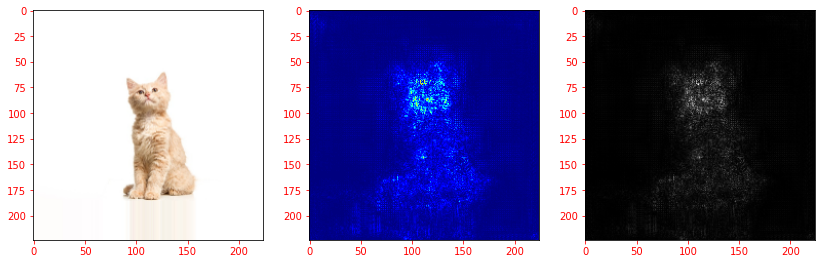

In [24]:
import tensorflow.keras as keras

def compute_saliency_map(model, img):
  
    img = keras.preprocessing.image.img_to_array(img)
    # expand the image, such that it has the shape (1, height, width, channels)
    img = np.expand_dims(img, axis=0)
    # preprocess image to get it into the right format for the model
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = tf.Variable(img, dtype=float)

    # use a gradient tape
    with tf.GradientTape() as tape:
        # feed the preprocessed image to the model
        pred = model(img, training=False)
        # TODO your code here: get the prediction with the highest probability
        loss = pred[0, np.argmax(pred, axis=-1)[0]] # the prediction with the highest score
        print(loss)
        # compute the gradient with respect to the image
        grads = tape.gradient(loss, img)
        # TODO your code here: take the absolute value of the gradient tf.math.abs
        abs_grad = tf.math.abs(grads)
        # TODO your code here: get the maximum across the channels of abs_grad
        max_abs_grad = tf.keras.backend.max(abs_grad, axis=-1)

        # TODO your code here: normalize to range between 0 and 1
        val_min = np.min(max_abs_grad)
        grad_norm = (max_abs_grad - val_min)/(np.max(max_abs_grad) - val_min)
    return grad_norm


model = tf.keras.applications.mobilenet_v2.MobileNetV2()
saliency_map = compute_saliency_map(model, img)

fig, ax = plt.subplots(1, 3, figsize=(14,5))
ax[0].imshow(img)
ax[1].imshow(saliency_map[0, :, :],cmap="jet")
ax[2].imshow(saliency_map[0, :, :],cmap="gray")


## t-SNE visualization (optional)

You can use the ImageNetes Apply t-SNE visualization on the last layer of the network that you chose.
You can use the [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) module from sklean library.

To create this visualization, you will need several images and their ground truth class. You could use some images from [imagenette](https://github.com/fastai/imagenette).

Feed the images through your model and save the activation maps of the layer just before the classification layer (create a new model starting from the pre-trained architecture that you used and set that layer as the input). Then, use t-SNE visualization to view the classes (the colors of the points should be determined by the class of those images).

# Deep-dream

Follow this [tutorial](https://www.tensorflow.org/tutorials/generative/deepdream) related to DeepDream.

# Part 2. Sequence models and image transformers



## Text generation at character level


Data processing 

- Load the training data [Poezii Eminescu.txt](https://ubbcluj.sharepoint.com/:t:/s/CVDL2021/EYeZJEN0aKNBs7xVblsELwgBaIpG7lF7VzDoMKs6fx7w0Q?e=QacxxQ) and determine the vocabulary for this problem 

- Encode the characters into a numerical representation: you should assign an id (number) for each character and, also, you should be able to determine retrieve the corresponding character of a given id 

- Split the training data into overlapping sequences of size _seq\_size_ . X will be an array of  _seq\_size_ from the text and the y (ground truth) will be the character that follows that sequence.

- Transform the data to one hot encoding 

Model creation 

- Build a simple recurrent network: input layer, LSTM layer, dense layer  (softmax activation) 

Training 

- Compile and train the model (categorical_crossentropy loss) 

- Use ModelCheckpoint callback to save the model https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint  

Text generation 

- Create a text sampling method: you could use a multinomial distribution to  sample the index of the next character from the softmax probas: 

https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html  

``
next_character = argmax(np.random.multinomial(1, preds)) 
``

Experiment with the temperature of softmax

Follow this [tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/) about image transformers.
